In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# extracting data and doing the fit on velocity

In [2]:
from ANEMO.edfreader import read_edf

import pickle
with open('../demo/result/param_Fit_AM.pkl', 'rb') as fichier:
    param = pickle.load(fichier, encoding='latin1')
with open('../demo/data/enregistrement_AM_2017-10-23_100057.pkl', 'rb') as fichier:
    file_exp = pickle.load(fichier, encoding='latin1')

datafile = '../demo/data/enregistrement_AM_2017-10-23_100057.asc'
data = read_edf(datafile, 'TRIALID')

In [3]:
def deco(axs) :
    axs.axvspan(arg.StimulusOn-start, arg.StimulusOf-start, color='k', alpha=0.2)
    axs.axvspan(arg.StimulusOf-start, arg.TargetOn-start, color='r', alpha=0.2)
    axs.axvspan(arg.TargetOn-start, arg.TargetOff-start, color='k', alpha=0.15)
    for s in range(len(arg.saccades)) :
        axs.axvspan(arg.saccades[s][0]-start, arg.saccades[s][1]-start, color='k', alpha=0.2)

In [4]:
def saccade(x, x_0, tau, x1, x2, T0, t1, t2, tr):
    
    time = x-T0
    T1 = t1
    T2 = t1+t2
    TR = T2+tr
    
    rho = (tau/T1) * np.log((1+np.exp(T1/tau))/2)
    rhoT = int(np.round(T1*rho))
    
    r = (tau/T2) * np.log((np.exp(T1/tau) + np.exp(T2/tau)) /2)
    rT = int(np.round(T2*r))
    Umax1 = (1/tau) * x1 / ((2*rho-1)*T1 - tau*(2-np.exp(-(rho*T1)/tau) - np.exp((1-rho)*T1/tau)))
    Umax2 = (1/tau) * (x2-x1) / ((2*r-1)*T2-T1)

    xx = []
    
    for t in time :
        if t < 0 :
            xx.append(x_0)
        elif t < rhoT :
            xx.append((x_0 +      Umax1*tau * ((t)    - tau*(1-np.exp(-t/tau)))))
        elif t < T1 :
            xx.append(x_0 + (x1 + Umax1*tau * ((T1-t) + tau*(1-np.exp((T1-t)/tau)))))
        elif t < rT :
            xx.append(x_0 + (x1 + Umax2*tau * ((t-T1) - tau*(1-np.exp(-(t-T1)/tau)))))
        elif t < TR :
            xx.append(x_0 + (x2 + Umax2*tau * ((T2-t) + tau*(1-np.exp((T2-t)/tau)))))
        else :
            xx.append(xx[-1])
    
    return xx

In [5]:
def Fit_saccade(position_x) :

    from lmfit import  Model, Parameters

    model = Model(saccade)

    params = Parameters()
    params.add('x_0', value=position_x[0], vary=False)
    params.add('tau', value=13, min=1, max=40)
    params.add('T0', value=2, min=0, max=len(position_x))
    params.add('t1', value=15, min=10, max=20)#len(position_x))
    params.add('t2', value=20, min=0, max=len(position_x)/2)
    params.add('tr', value=0, min=0, max=10)
    params.add('x1', value=-2, min=-5, max=5)
    params.add('x2', value=-3, min=-5, max=5)

    result_deg = model.fit(position_x, params, x=np.arange(len(position_x)), nan_policy='omit')

  
    return result_deg


In [6]:
from ANEMO import ANEMO

block, trial, sacc = 0, 99, 0
arg = ANEMO.arg(data, file_exp, trial, block)


trial_data = trial + arg.N_trials*block
time, t_0 = arg.trackertime, arg.t_0
start, start1 = arg.TargetOn, arg.TargetOn-t_0

data_1 = (arg.data_x-(arg.data_x[arg.StimulusOf-t_0])) / arg.px_per_deg

0.5504123817372344 2.3213776549363834 -1.2209328678391431 -0.6420743151580197 
 1.9601634409761484 13.100854344918359 14.11274734556632 0.0


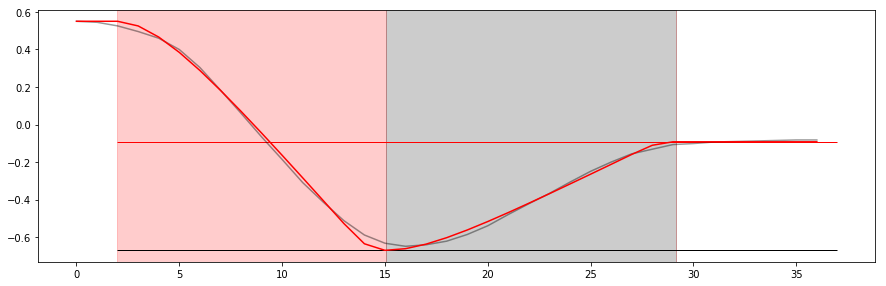

In [7]:
fig_width= 15
fig, axs = plt.subplots(1, 1, figsize=(fig_width, (fig_width/2)/1.6180))

debut, fin = 0, 15
data_sacc  = data_1[arg.saccades[sacc][0]-t_0+debut:arg.saccades[sacc][1]-t_0+fin]
f = Fit_saccade(data_sacc)

print(f.values['x_0'], f.values['tau'], f.values['x1'], f.values['x2'],
      '\n', f.values['T0'], f.values['t1'],f.values['t2'], f.values['tr'])

axs.axvspan(f.values['T0'], f.values['T0']+f.values['t1'], color='r', alpha=0.2)

axs.axvspan(f.values['T0']+f.values['t1'], f.values['T0']+f.values['t1']+f.values['t2'], color='k', alpha=0.2)
axs.axvspan(f.values['T0']+f.values['t1']+f.values['t2'],
            f.values['T0']+f.values['t1']+f.values['t2']+f.values['tr'], color='r', alpha=0.2)


axs.hlines(f.values['x1']+f.values['x_0'], f.values['T0'], len(data_sacc), color='k', lw=1)
axs.hlines(f.values['x2']+f.values['x_0'], f.values['T0'], len(data_sacc), color='r', lw=1)

axs.plot(data_sacc, color='k', alpha=0.4)
axs.plot(f.best_fit, color='R');

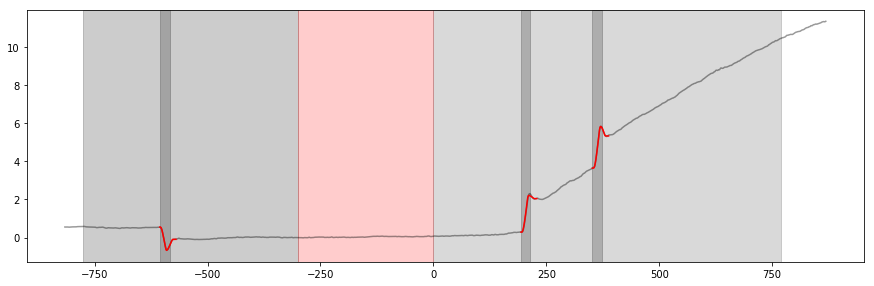

In [8]:
fig_width= 15
fig, axs = plt.subplots(1, 1, figsize=(fig_width, (fig_width/2)/1.6180))

deco(axs)
axs.plot(time-start, data_1, color='k', alpha=0.4)

debut, fin = 0, 15

for s in range(len(arg.saccades)):
    data_sacc  = data_1[arg.saccades[s][0]-t_0+debut:arg.saccades[s][1]-t_0+fin]
    f = Fit_saccade(data_sacc)
    axs.plot(time[arg.saccades[s][0]-t_0+debut:arg.saccades[s][1]-t_0+fin]-start,
             f.best_fit , 'r')